In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from pyscf import lib, gto, scf
import pyqmc
import h5py

This function computes the mean-field solution and saves the results to the file specified.

In [2]:
def mean_field(chkfile):
    mol = gto.M(atom = "He 0. 0. 0.", basis='bfd_vdz', ecp='bfd', unit='bohr')

    mf = scf.RHF(mol)
    mf.chkfile = chkfile
    mf.kernel()
    return mol, mf

This function runs VMC, recovering the mean-field objects from `chkfile`. These could be run in completely different processes.

If `hdffile` exists, then the configurations will be reloaded from it and the run will be continued. You can run this as many times as you like and the statistics will get better.

In [16]:
def runvmc(chkfile, wffile, hdffile):
    #recover the mean-field objects
    mol = lib.chkfile.load_mol(chkfile)
    mf = scf.RHF(mol)
    mf.__dict__.update(scf.chkfile.load(chkfile, 'scf'))

    #Set up our MC variables and wave function
    wf, _ = pyqmc.default_sj(mol,mf)
    hdf = h5py.File(wffile, 'r')
    grp = hdf['wf']
    for k in grp.keys():
        wf.parameters[k] = np.array(grp[k])
    hdf.close()
    
    accumulators = {'energy': pyqmc.EnergyAccumulator(mol) } 
    #This will get 
    configs = pyqmc.initial_guess(mol, 1000)
    #hdf = h5py.File(hdffile,'a')

    pyqmc.vmc(wf, configs, accumulators=accumulators, hdf_file = hdffile)


In [9]:
def optimize(chkfile, wffile):
    #recover the mean-field objects
    mol = lib.chkfile.load_mol(chkfile)
    mf = scf.RHF(mol)
    mf.__dict__.update(scf.chkfile.load(chkfile, 'scf'))
    wf, to_opt = pyqmc.default_sj(mol, mf)
    accumulator = pyqmc.gradient_generator(mol, wf, to_opt)
    coords = pyqmc.initial_guess(mol, 1000)
    #hdf = h5py.File(wffile, 'a')
    wf, df = pyqmc.line_minimization(wf,coords, accumulator, hdf_file = wffile)


A simple analysis script to check on the progress of your calculation.

In [6]:
def analyze(hdffile):
    hdf = h5py.File(hdffile, 'r')
    energy = np.array(hdf['energytotal'])
    for nb in [50, 20, 10]:
        reblock = pyqmc.avg_reblock(energy, nb)

        print(nb, np.mean(reblock), np.std(reblock)/np.sqrt(len(reblock)) )


Here we run the mean-field calculation. It's a good idea to run analyze() to make sure that the solution is similar to what you would expect. 

In [7]:
chkfile = 'he.chk'
hdffile = 'he.hdf5'
wffile = "savewf.hdf5"

#This is so we can start over each time we run!
#Don't do this if you want to save your data.
for filenm in [chkfile, hdffile, wffile]:
    if os.path.isfile(filenm):
        os.remove(filenm)
        
mol, mf = mean_field(chkfile)
mf.analyze()

converged SCF energy = -2.86193223020366
**** MO energy ****
MO #1   energy= -0.917801424375274 occ= 2
MO #2   energy= 0.727613019225335  occ= 0
MO #3   energy= 0.727613019225335  occ= 0
MO #4   energy= 0.727613019225338  occ= 0
MO #5   energy= 1.58197375047964   occ= 0
 ** Mulliken atomic charges  **
charge of  0He =      0.00000
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000,  0.00000


((array([1.99999047e+00, 9.53120630e-06, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00]), array([0.])), array([0., 0., 0.]))

We can now run VMC on our Slater-Jastrow wave function. Each time we run it, the error bars will decrease.


In [10]:
optimize(chkfile, wffile)

polynomial fit [ 0.38595638 -0.2581687  -2.86438789]
estimated minimum 0.33445320689407865
estimated minimum adjusted 0.2
polynomial fit [ 0.02297474 -0.04513711 -2.88764676]
estimated minimum 0.9823204519255263
estimated minimum adjusted 0.2
polynomial fit [ 0.00396502 -0.00796056 -2.90948338]
estimated minimum 1.003849685868595
estimated minimum adjusted 0.2
polynomial fit [ 1.52242842e-03 -7.76111205e-04 -2.89817482e+00]
estimated minimum 0.2548925110009335
estimated minimum adjusted 0.2
polynomial fit [ 7.04554176e-04 -3.47647747e-03 -2.89927065e+00]
estimated minimum 2.467147018947053
estimated minimum adjusted 0.2
polynomial fit [ 6.56084205e-04 -1.10019197e-03 -2.88653324e+00]
estimated minimum 0.8384533293209676
estimated minimum adjusted 0.2
polynomial fit [ 3.62397056e-04  4.03333589e-03 -2.89987401e+00]
estimated minimum -5.564802231658572
estimated minimum adjusted -0.04
polynomial fit [ 4.11622710e-04  1.40760374e-04 -2.90224493e+00]
estimated minimum -0.17098227449246525


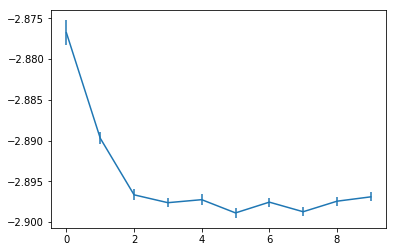

In [11]:
hdf = h5py.File(wffile,'r')
import matplotlib.pyplot as plt
%matplotlib inline
plt.errorbar(hdf['iteration'], hdf['energy'], hdf['energy_error'])
hdf.close()

polynomial fit [ 2.81793506e-04 -4.57400958e-04 -2.89757407e+00]
estimated minimum 0.8115888913440752
estimated minimum adjusted 0.2
polynomial fit [ 7.74058489e-04 -2.37096519e-03 -2.89251048e+00]
estimated minimum 1.5315155249923975
estimated minimum adjusted 0.2
polynomial fit [ 3.59188925e-04  2.69002542e-03 -2.91308461e+00]
estimated minimum -3.7445829136737383
estimated minimum adjusted -0.04
polynomial fit [ 2.75861785e-04  5.42366531e-03 -2.90101834e+00]
estimated minimum -9.830403474386488
estimated minimum adjusted -0.04
polynomial fit [ 1.18695171e-03 -6.92077545e-03 -2.90655810e+00]
estimated minimum 2.9153567843964967
estimated minimum adjusted 0.2
polynomial fit [ 4.99957505e-05  1.47160881e-03 -2.90014067e+00]
estimated minimum -14.717338955993885
estimated minimum adjusted -0.04
polynomial fit [ 1.66009875e-04 -2.10836191e-03 -2.89148179e+00]
estimated minimum 6.350109928059387
estimated minimum adjusted 0.2
polynomial fit [ 1.21280229e-04  4.79919333e-04 -2.89776118e+0

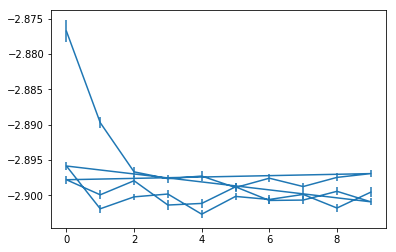

In [14]:
optimize(chkfile, wffile)
hdf = h5py.File(wffile,'r')
import matplotlib.pyplot as plt
%matplotlib inline
plt.errorbar(hdf['iteration'], hdf['energy'], hdf['energy_error'])
hdf.close()

In [17]:
runvmc(chkfile, wffile, hdffile)
analyze(hdffile)

50 -2.895825 0.0017995350346643338
20 -2.8958244 0.0022317642318091194
10 -2.895825 0.0023125718979216214


In [18]:
runvmc(chkfile, wffile, hdffile)
analyze(hdffile)

50 -2.8986046 0.0012378578139943168
20 -2.8986046 0.0013842632335268324
10 -2.8986049 0.0013459594083618923


In [19]:
runvmc(chkfile, wffile, hdffile)
analyze(hdffile)

50 -2.899013 0.0009016064370162578
20 -2.899013 0.0009358562918871788
10 -2.8990133 0.0009488583188982934
